# Project 06. Pricing Test

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

# Table of Contents
  1. [Read Data](#readdata)
  2. [Question 1](#question1)

<a id='read_data'></a>
## Read Data

In [3]:
test = pd.read_csv('C:/Users/xiaoj/Desktop/CS/collection of data science-take home challenges/Data/6. Pricing_Test/test_results.csv')
test.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316800 entries, 0 to 316799
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           316800 non-null  int64 
 1   timestamp         316800 non-null  object
 2   source            316800 non-null  object
 3   device            316800 non-null  object
 4   operative_system  316800 non-null  object
 5   test              316800 non-null  int64 
 6   price             316800 non-null  int64 
 7   converted         316800 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 19.3+ MB


In [5]:
test['source'].nunique()

12

In [6]:
test['device'].nunique()

2

In [7]:
test['operative_system'].nunique()

6

In [8]:
user = pd.read_csv('C:/Users/xiaoj/Desktop/CS/collection of data science-take home challenges/Data/6. Pricing_Test/user_table.csv')
user.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [9]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275616 entries, 0 to 275615
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  275616 non-null  int64  
 1   city     275616 non-null  object 
 2   country  275616 non-null  object 
 3   lat      275616 non-null  float64
 4   long     275616 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 10.5+ MB


In [10]:
user['country'].nunique()

1

In [11]:
user['city'].nunique()

923

Since in user table the 'country' column only has one country (USA) and a wide city distribution, there are not useful information to the problems, so just ignore this table temporarily.

In [22]:
# check if there are any problem with the data
test.groupby(['test','price'])['user_id'].count()

test  price
0     39       202517
      59          210
1     39          155
      59       113918
Name: user_id, dtype: int64

It can be seen that there are actually some problems with the data since in control there are some users who see price 59 and in test some users can see the price 39. So, before answer the question, we should remove them first.

In [33]:
# remove the unvalid data
test = test[((test['test'] ==0) & (test['price'] == 39)) | ((test['test'] == 1) & (test['price'] == 59))]

<a id='question1'></a>
## Question 1

In [19]:
# create revenue for software
test['per_revenue'] = test['price'] * test['converted']
total_revenues = test.groupby('test')['per_revenue'].sum()
revenues

test
0    157465
1    104587
Name: per_revenue, dtype: int64

In [38]:
# check randominess
count = test[['device', 'test', 'per_revenue']].groupby(['test','device']).count().reset_index()
count

,test,device,per_revenue
0,0,mobile,120369
1,0,web,82148
2,1,mobile,65898
3,1,web,48020


In [39]:
count.loc[count['test'] == 1, 'per_revenue'] = count.loc[count['test'] == 1, 'per_revenue'] / 113918
count.loc[count['test'] == 0, 'per_revenue'] = count.loc[count['test'] == 0, 'per_revenue'] / 202517
count

,test,device,per_revenue
0,0,mobile,0.594365
1,0,web,0.405635
2,1,mobile,0.578469
3,1,web,0.421531


In [45]:
test[['source','per_revenue','test']]

,source,per_revenue,test
0,ads_facebook,0,0
1,seo-google,0,0
2,ads-bing,0,0
3,direct_traffic,0,1
4,ads_facebook,0,0
...,...,...,...
316795,ads_facebook,0,0
316796,direct_traffic,0,0
316797,ads-google,0,0
316798,friend_referral,0,0


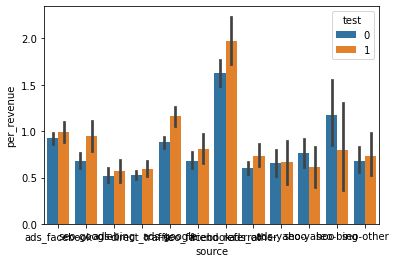

In [43]:
fig,ax = plt.subplots()
sns.barplot(x='source', y='per_revenue', hue='test', data=test)